# The Network of Terms in Bruno Latour's An Inquiry into Modes of Existence
## By Moses Boudourides & Sergios Lenis 

**IMPORTANT**: To use this notebook, you'll need to

1. Install IPython Notebook (easiest way: use [Anaconda](http://store.continuum.io))
2. Download this notebook and all other Python scripts used here from [https://github.com/mboudour/WordNets](https://github.com/mboudour/WordNets)
3. Run `ipython notebook` in the same directory where notebook and scripts were put

<a href="http://creativecommons.org/licenses/by/4.0/"><img alt="Creative Commons License" style="border-width:0" src="http://i.creativecommons.org/l/by/4.0/88x31.png" /></a><br />This work is licensed under a <a rel="license" href="http://creativecommons.org/licenses/by/4.0/">Creative Commons Attribution 4.0 International License</a>.

In [1]:
# All these imports are needed for the following cells to run

import nltk
import os
import re
import itertools
from nltk.tokenize import sent_tokenize, word_tokenize
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import codecs
from textblob import TextBlob
import pandas as pd
%matplotlib inline 
%load_ext autoreload

In [2]:
# Opening and reading Latour's AIME in NLTK

f = codecs.open('Latour_AIME.txt', "r", encoding="utf-8")
fTemp = codecs.open("tempASCII", "w", encoding="ascii", errors="ignore")
fTemp.write('Latour_AIME_temp.txt')
book=f.read()
title="Latour's AIME"
blobbook = TextBlob(book)

## Randomly selected terms from a given list of terms appearing in Latour's AIME

In [3]:
selectedTerms=[
'reproduction', 'metamorphosis', 'habit', 'technology', 'fiction', 'reference', 'politics', 'law', 'religion', 
'attachment', 'organization', 'morality', 'network', 'preposition', 'risk', 'crises',  
'hesitation', 'obstacle', 'detour', 'vacillation', 'material', 'form', 'distance', 
'impossibility', 'possibility', 'being', 'represent', 'action', 'time', 'desire', 'lacks', 'disorder', 
'order', 'anxiety', 'means', 'ends', 'surprise', 'association', 'category', 'mistake', 'horror', 'hiatus', 'existent', 
'emotion', 'transformation', 'ingenuity', 'invention', 'zigzag', 'inscription', 'circle', 
'production', 'person', 'goods', 'bads', 'script', 'exploration', 'link', 'actor', 'connection', 'heterogeneous', 
'detection', 'crossing', 'displacement', 'translation', 'force', 'society', 'differences', 'install', 
'protect', 'destroy', 'attention', 'veil', 'essence', 'fail', 'imitate', 
'delegation', 'world', 'information', 'art', 'resistance', 'figuration', 'entities', 'reconnect', 'enunciation', 
'presence', 'interest', 'calculation', 'scruple', 'traverse', 'inquiry', 'freedom', 'mode', 'template', 'speak', 
'trope', 'figure', 'reason', 'interpretive', 'frame', 'empire', 'passion', 'assemble', 'civilization', 
'modern', 'global', 'existence'
]

k = 10 # Number of terms to be selected from the previous default list
selectedTerms = random.sample(selectedTerms, k)

dfst=pd.DataFrame(columns=["%s selected terms" %title, "Frequencies"])
u=1
selectedTermsDic={}
for l in selectedTerms: 
    dfst.loc[u]=[l,blobbook.word_counts[l]]
    selectedTermsDic[l]=blobbook.word_counts[l]
    u+=1

n = k
print "The total number of selected terms in %s is %i. The following table shows the first %i entries." %(title,len(selectedTerms),n)  
dfst.head(n)

The total number of selected terms in Latour's AIME is 10. The following table shows the first 10 entries.


,Latour's AIME selected terms,Frequencies
1,presence,31
2,production,13
3,essence,18
4,goods,29
5,inscription,9
6,attention,33
7,mode,297
8,detour,13
9,association,9
10,transformation,27


## User-Defined List of Terms in Latour's AIME

In [4]:
## Comment out the following snippet if you want to use a user-defined list of terms

# selectedT=raw_input('Type L for a list of terms or I for terms to be added one by one. Type "Enter" to exit!')
# if selectedT.strip() == 'L':
#     selectedTerms=input('Paste list')
# elif selectedT.strip() == 'I':
#     selectedTerms=[]
#     while True:
#         selec=raw_input('Give the next term')
#         if len(selec.strip()) >1:
#             selectedTerms.append(selec)
#         else:
#             break
# dfst=pd.DataFrame(columns=["%s selected terms" %title, "Frequencies"])
# u=1
# selectedTermsDic={}
# for l in selectedTerms: 
#     dfst.loc[u]=[l,blobbook.word_counts[l]]
#     selectedTermsDic[l]=blobbook.word_counts[l]
#     u+=1
# n = len(selectedTerms)
# print "The total number of selected terms in %s is %i. The following table shows the first %i entries." %(title,len(selectedTerms),n)  
# dfst.head(n)

In [5]:
LatourAIMEterms = {}
dfl=pd.DataFrame(columns=["Selected terms", title])
u=1
for l,v in selectedTermsDic.items(): 
    LatourAIMEterms[l]= v
    dfl.loc[u]=[l,v]
    u+=1

## This function counts co-occurrences of the selected tems in the sentences of a book

In [6]:
def occurrences(source,terms):
    ALL_sentences=sent_tokenize(source)
    combinations_terms = list(itertools.combinations(terms,2))
    n = len(combinations_terms)
    occurlist =[]
    for i in range(n):
        for j in ALL_sentences:
            temp= list(combinations_terms[i])            
            out  = re.compile(str(temp[0])+'(.*?)'+str(temp[1]), re.DOTALL |  re.IGNORECASE).findall(j)
            if out :
                occurlist.append(tuple(temp))
            out2  = re.compile(str(temp[1])+'(.*?)'+str(temp[0]), re.DOTALL |  re.IGNORECASE).findall(j)
            if out2 :
                occurlist.append(tuple(temp))
    occurdict={}
    for i in occurlist:
        if i not in occurdict:
            occurdict[i] = 1
        else:
            occurdict[i] = occurdict[i]+1
    return occurdict

Latour_AIMEdict = occurrences(book,selectedTermsDic)

## This function constructs the graph of selected terms tied by their co-occurrences in sentenses of a book

In [7]:
def makegraph(occurrences):
    G = nx.Graph()
    for ed,wei in occurrences.items():   
        if ed[0] not in G:
            wei=1
        else:
            wei=G.node[ed[0]]['weight']+1
        if ed[1] not in G:
            weib=1
        else:
            weib=G.node[ed[1]]['weight']+1
        G.add_edge(ed[0],ed[1],weight=wei)
        G.add_node(ed[0],label=ed[0],weight=wei)
        G.add_node(ed[1],label=ed[1],weight=weib)
        
    return G

GLatour_AIME = makegraph(Latour_AIMEdict)

## Plotting the graph of selected terms in Latour's AIME

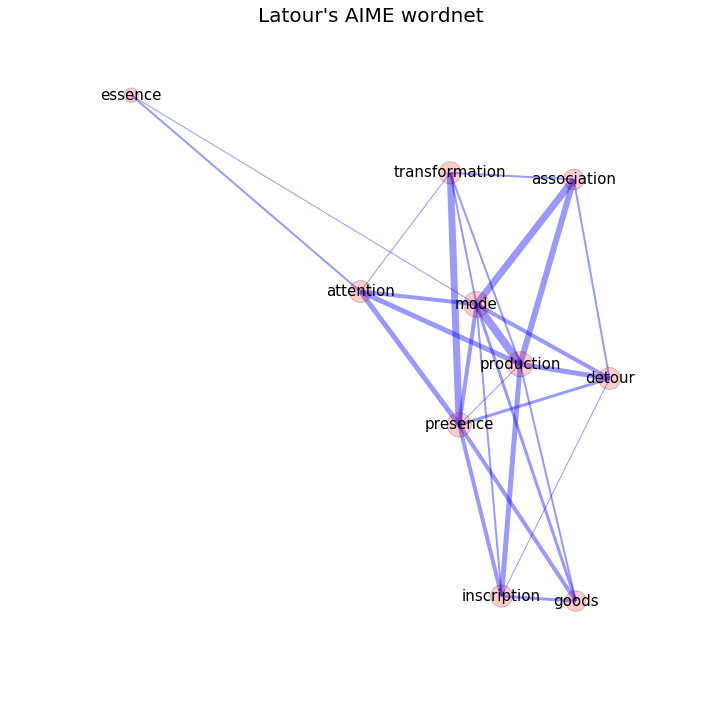

In [8]:
from tools import draw_network
# pos=nx.graphviz_layout(GLatour_AIME)
pos=nx.spring_layout(GLatour_AIME)
sstt="%s wordnet" %title
possit=draw_network(GLatour_AIME,sstt,pos=pos,with_edgewidth=True,withLabels=True,labfs=15,valpha=0.2,ealpha=0.4,labelfont=15,with_node_weight=True,node_size_fixer=300.)

## Computing centralities of selected terms in the graph of Latour's AIME

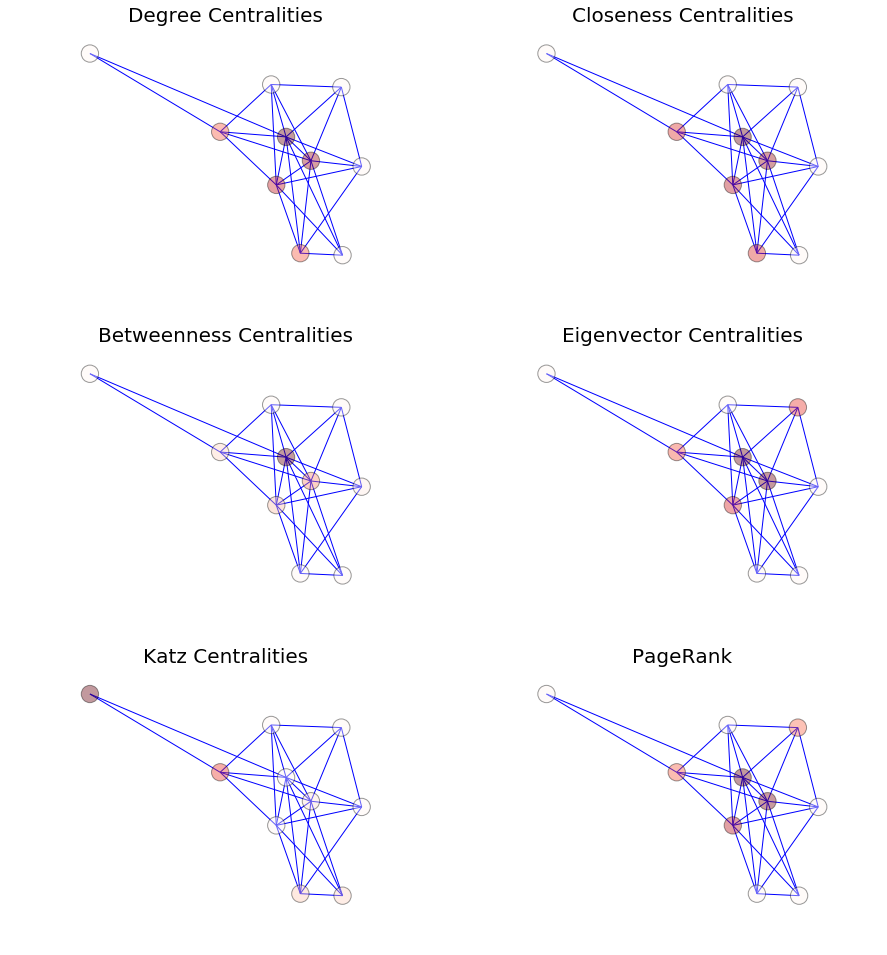

In [9]:
from tools import draw_centralities_subplots
centrali=draw_centralities_subplots(GLatour_AIME,pos,withLabels=False,labfs=5,figsi=(15,22),ealpha=1,vals=True)

## The table of centralities of selected terms in the graph of Latour's AIME

In [10]:
dfc=pd.DataFrame()
# dfc.insertimport pygraphviz
# # pyg(0,'Selected terms',centrali[centrali.keys()[0]].keys())
u=0
for i,k in centrali.items():
    dfc.insert(u,i,k.values())
    u+=1
dfc.insert(0,'Selected terms',centrali[centrali.keys()[0]].keys())
dfc

,Selected terms,closeness_centrality,katz_centrality,betweenness_centrality,page_rank,eigenvector_centrality,degree_centrality
0,inscription,0.692308,0.136549,0.006944,0.080535,0.245325,0.555556
1,goods,0.642857,0.110352,0.000000,0.067141,0.198352,0.444444
2,presence,0.818182,-0.161017,0.060185,0.142986,0.489579,0.777778
3,essence,0.562500,0.663306,0.000000,0.028788,0.349670,0.222222
4,attention,0.692308,0.428385,0.041667,0.095507,0.045579,0.555556
5,detour,0.692308,-0.112055,0.016204,0.079271,0.479184,0.555556
6,production,0.900000,0.081154,0.099537,0.167505,0.279334,0.888889
7,mode,1.000000,0.009735,0.252315,0.174482,0.273248,1.000000
8,transformation,0.692308,-0.486096,0.016204,0.075808,0.317831,0.555556
9,association,0.642857,-0.253449,0.006944,0.087977,0.230461,0.444444


## Detecting communities of selected terms in the graph of Latour's AIME

Number of communities of Latour's AIME wordnet = 3
Community partition of Latour's AIME wordnet:
[['inscription', 'goods'], ['presence', 'essence', 'attention', 'transformation'], ['detour', 'production', 'mode', 'association']]
Community modularity of Latour's AIME wordnet = 0.1171


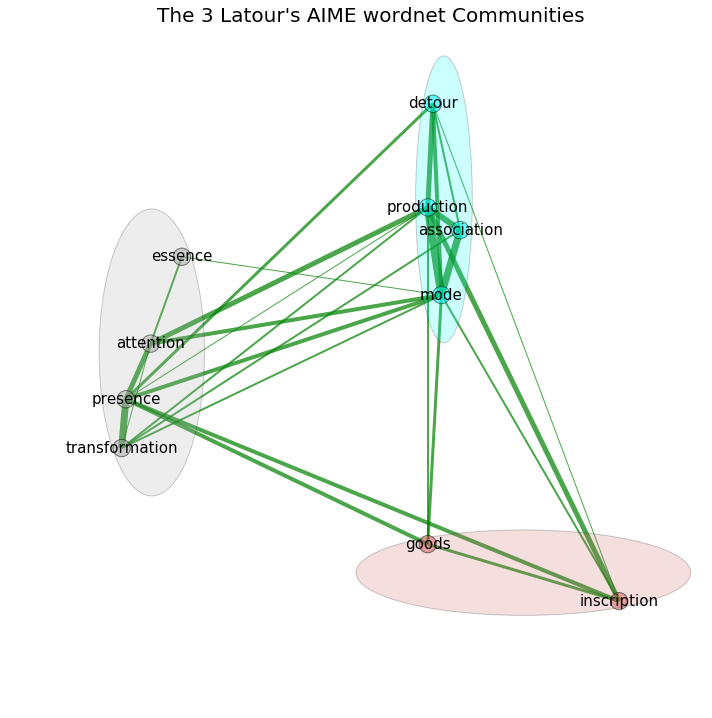

In [11]:
%autoreload 2
from tools import draw_comms, modul_arity, print_communities

part,nodper=print_communities(GLatour_AIME,sstt)

d=0.8 
dd=0.8
c=1.2
cc=1.4
alpha=0.2
ealpha=.7
vcc={}
sstta="The %s %s Communities" %(max(part.values())+1,sstt)

draw_comms(GLatour_AIME,GLatour_AIME.nodes(),[],[],[] ,part,part,d,dd,c,cc,alpha,ealpha,nodper,sstta,titlefont=20,labelfont=15,valpha=0.5)